
# Week 6 - Discovering Patterns: Clusters & Topics

This week, we seek to seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

Note: This proposal is the collaborated work between our group members: Linh Dinh, Roberto Barroso Luque, Lily Grier

# ***What?*** 
<200 words

We plan to conduct an exploration of the semantic relationship between US presidential speeches and executive orders. Specifically, we are interested in how the issues a president discusses in their speeches map onto the executive actions they take. We plan to examine two corpuses: a dataset of presidential speeches (https://millercenter.org/the-presidency/presidential-speeches) and a corpus of executive summaries from Clinton to Trump (possibly including Biden for analyses that won’t be tainted by having only a few months’ of data). We choose to consider the role of the president here and not other political actors because we believe the president has great influence over public perception of policy issues. Further, in recent decades, executive orders have become a more mainstream way for a president to assert their power. It is not uncommon for there to be back-and-forths between successive presidents of alternate parties striking, then reinstating, then striking, then reinstating a particular order. We are interested in examining these interplays, and in looking at how presidents frame and justify the actions they take to the public. A question we have is whether presidents from different parties who focus on similar policy issues might frame those issues in different ways.
    

## ***Why?***
<200 words

This exploration could reveal how the prominence of certain policy issues have evolved over time. In thinking about today’s policy issues, it is important to understand how those issues rose in pertinence. Our study will shed further light on the interplay between public attention and a president’s actions. It may be the case that certain issues garner public support and then the president acts on those issues, or it could be that presidents speak on issues politically important to them, and then the public reacts to those issues, shaping the next president’s actions. This type of analysis can also help us better understand the legacies of our presidents. For example, Obama is known for the Affordable Care Act, but it may also be the case that he reflected the American public’s concerns around climate change in his speeches and actions. Seeing the ebb and flow of policy prominence could help us understand why it’s taken so long to make progress in so many realms and give concrete examples of “one step forward, two steps back” phenomena in our political system. Understanding these patterns is crucial to creating a strategy to effect lasting policy change in the future.
     

## ***How?***
<400 words

We plan to break our investigation into a series of pieces to understand the semantic relationship between executive orders and presidential speeches. 
The first step (which we already completed) was to compile the corpus through web-scraping. We completed two web-scraping modules to generate a corpus of presidential speeches and a corpus on executive orders. 
We have pre-processed the text by removing white space, non-alpha numeric characters, and stop words. We then lemmatized and tokenized each document.
We will then use semantic analysis including dependency parsing, POS tagging and collocation analysis to understand the patterns and characteristics unique to speeches and orders. One exploration we plan to conduct is a comparison of sentence depths and linguistic complexity in speeches across different presidents. We may separate speeches by specific topics and see if certain word groups are more likely to occur when a Republican president talks about a topic than when a Democratic president talks about a topic (e.g., using “energy security” vs. “climate change” when talking about environmental policy). We will examine the role of factors such as party affiliation, president, year of event, and whether the president’s party also had a majority in the house/senate.
In addition, we will use sentiment analysis and POS tagging to understand the sentiment different presidents use towards specific named entities such as organizations and types of regulations. We will identify identities that may be of interest through topic modeling and seeing which noun phrases appear frequently, but some topics we may start with are healthcare (and policies such as single-payer healthcare), climate change/environmental regulation/energy production, and major actors in international relations (countries such as Iran and China).
We will then convert our documents into vector form through a count or tf-idf vectorizer. This is especially important to parse out semantic differences in executive orders, which tend to have a rigid structure and don’t vary much across documents.
We will apply both hard clustering methods (k-means, hierarchical clustering and DBSCAN) to understand what features present in our corpus best divide documents into different clusters.
Once we understand the distribution of clusters in our data we will use classification to determine the best predictors of “successful” executive orders (those which are not revoked). 
Finally, we will synthesize these results to understand how presidential speeches and executive orders interact, the dynamics among different presidents and the adversarial or collaborative relationship among them.

Cell 5:

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

We are studying how the executive branch of government communicates its goals, purposes and actions with the public, and how it attempts to realize these goals through executive orders. Furthermore, we are investigating the dynamics between various occupants of the oval office and how their unique use of language, party affiliation, and time in office differentiate them. We believe combining an analysis of executive orders and presidential speeches will illuminate the ways that public rhetoric and policy interact. We will see how issue framings translate to concrete policy decisions. Our analysis is limited in that we are only using executive orders to look at policy, while a substantive degree of policy change occurs through legislation passed through the House and Senate. 


Furthermore, our work seeks to make inferences about relationships between the Democratic and Republican parties in the United States, the role they play in a democratic society, and the impact presidential speeches have on policy changes. Our analysis is limited in that we are only including presidents in our corpus; future work could include other elected officials. It would be interesting to look at House members who draft legislation and the ways they communicate about policy issues (or how Senators vote on issues and the speeches they make to their home states). Our work will reveal the issues that were important to the American public to the extent that those issues are reflected in presidential rhetoric and action, but adding on a layer of public sentiment (e.g., polling results, news articles, social media) in future iterations of the project would better contextualize our findings. 
Future research could also include presidential communications such as press releases and social media activity (i.e., Twitter) to develop a more thorough understanding of the relationship between presidential rhetoric and legislation. 


## ***Which (words)?***
<300 words

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [2]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [3]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [4]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,text,category,source_file
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
5,What is the value of an SE (HDFD) 4/20?\n\n-David,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
6,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
7,"\n\n\n Nope. The Apple 16"" monitor does not...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
8,\n\nIs it a hidden option? I'm using PowerStr...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
9,\n\n\nThe previous article referred to the fac...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [5]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


I'm pretty sure that you're very familiar with the cell above now, but let's go through the concepts again. 

What do we want to do here? We want to do vectorization, i.e., converting texts into numerical features (vectors) as required by machine learning algorithms. And this is what feature_extraction module does: to extract features from texts in a format as required by ML algorithms. feature_extraction module has four classes: CountVectorizer, DictVectorizer, TfidfVectorizer, and FeatureHasher. Here, we use CountVectorizer, but we'll also use TfidfVectorizer as well below.

There are various strategies by which we extract features. Here, we use CountVectorizer, and, in particular, we use 'Bag of Words' representation. In other words, the features we hope to extract from the texts are each individual token occurrence frequency. We simply count the the occurrence of each token in each document. So, here, we get a document-term-matrix, in which documents are characterized by the occurrences of tokens. Other forms of features, such as the relative position information of words, are ignored. We'll see other types of representations and strategies as well soon, such as N-gram (by the way, we can do n-gram with CountVectorizer. CountVectorizer class takes a set of parameters, such as analyzer, which you can specify the n-gram). 

the first line of the cell above instantiate a class, CountVectorizer(). In other words, you created an instance, or realization of a class. What is a class and what does instantiation mean? That's a long story, maybe for next time.

This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [6]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [7]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

What is the toarray() function here? It's similar to todense()--todense() and toarray() both returns a dense representation of a matrix; however, todense() returns a matrix representation while toarray() returns a ndarray representation.

We can also lookup the indices of different words using the Vectorizer

In [8]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [10]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [11]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.08265545268171724),
 ('certain', 0.05464092321093494),
 ('apple', 0.19706119834212132),
 ('13', 0.05749878121929968),
 ('rgb', 0.07820822067701588),
 ('monitors', 0.0749569030656185),
 ('there', 0.10567912764152107),
 ('has', 0.1109950967372947),
 ('been', 0.05330795380898169),
 ('problem', 0.21470375597395805),
 ('with', 0.09901319943986409),
 ('the', 0.19389877721110985),
 ('high', 0.1817286448065436),
 ('voltage', 0.19389877721110985),
 ('capasitor', 0.33279218254193177),
 ('knows', 0.18819404816424326),
 ('about', 0.08243502153417578),
 ('this', 0.1619412292430009),
 ('and', 0.13074268623716792),
 ('is', 0.16299450361806797)]

Let's see what we're doing here. First, you need to know what vocabulary\_ does. vocabulary\_ is an attribute of the CountVectorizer, which gives you a mapping of terms to feature indices. It gives you all the terms and their feature indices, so it's a dictionary. So, by doing "ngCountVectorizer.vocabulary\_.keys()", we get the keys of the dictionary, which are the terms. 

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [12]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [13]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
                              ...                        
2345    I was wondering if anyone out in net-land have...
2346    \n\n\n\n\nI sold my '86 Sprint last April with...
2347    Actually I wasn't too surprised, since I bough...
2348    \n\nI couldnt agree more.  That is how it SHOU...
2349    \nWarren Brown, the Washington Post's auto wri...
Name: text, Length: 2350, dtype: object

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [14]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [15]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [16]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [17]:
km.fit(newsgroupsTFVects)

KMeans(n_clusters=4)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [18]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', 'mean_tweedie_deviance', 'median_absolute_error', 'mult

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [19]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,text,category,source_file,kmeans_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,3
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,1
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,3
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,1
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,1
...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,1
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,1


We can also look at the distinguishing features in each cluster:

In [20]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 car
 cars
 engine
 good
 just
 like
 think
 don
 dealer
 oil


Cluster 1:
 window
 use
 thanks
 like
 does
 know
 server
 using
 problem
 motif


Cluster 2:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 interested
 email
 sell


Cluster 3:
 drive
 mac
 apple
 monitor
 card
 scsi
 modem
 know
 simms
 hard




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [21]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [22]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [23]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

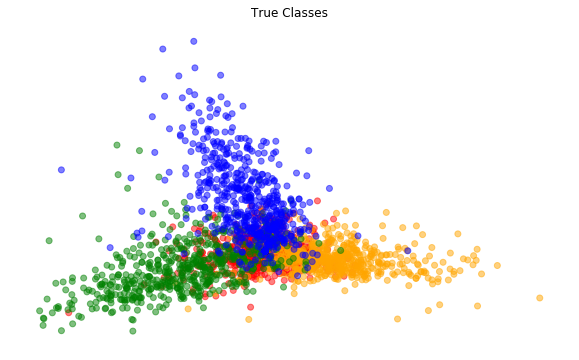

In [24]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

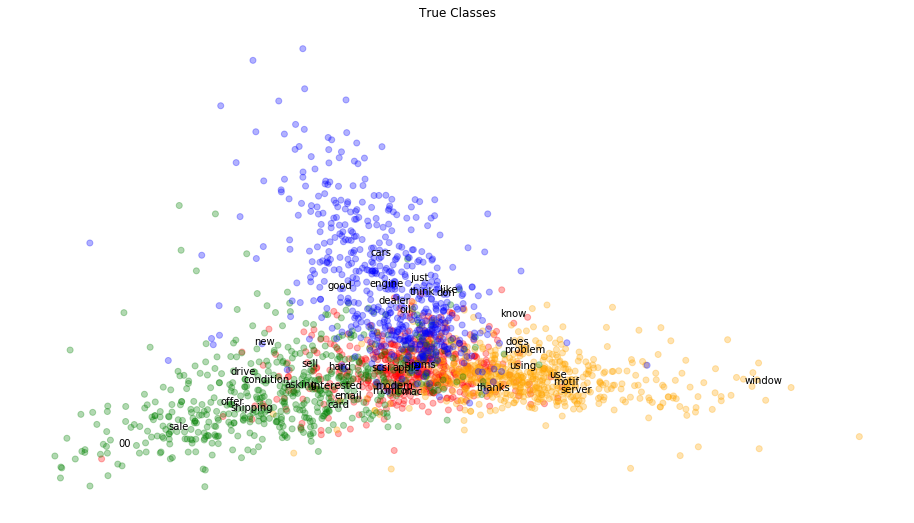

In [25]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [26]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

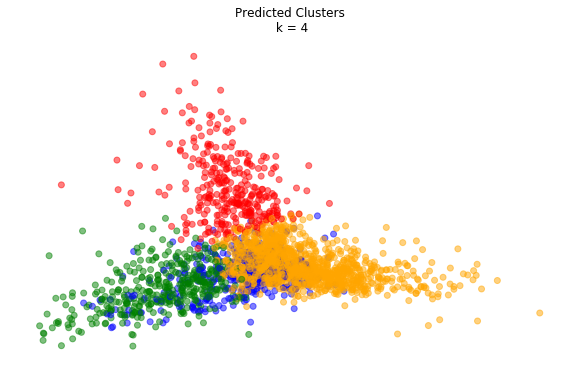

In [27]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [28]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(n_clusters=3)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [215]:
def plotSilhouette(n_clusters, X, reduced_data, pca):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


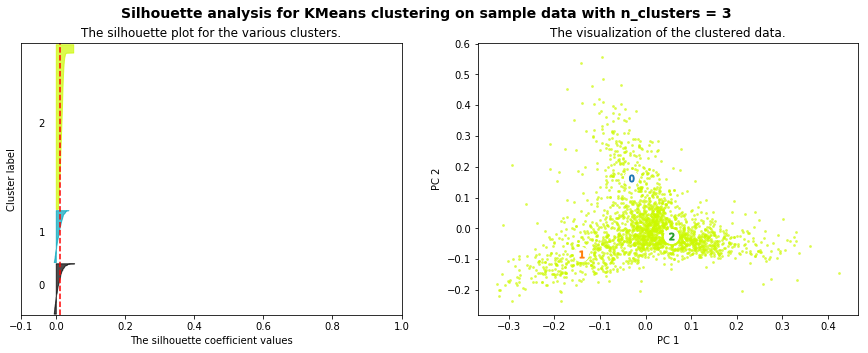

For n_clusters = 3, The average silhouette_score is : 0.013


In [217]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X, reduced_data, pca)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


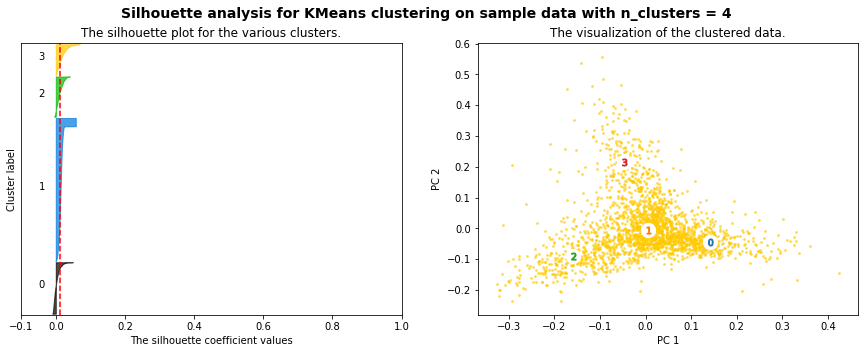

For n_clusters = 4, The average silhouette_score is : 0.012


In [198]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X, reduced_data)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


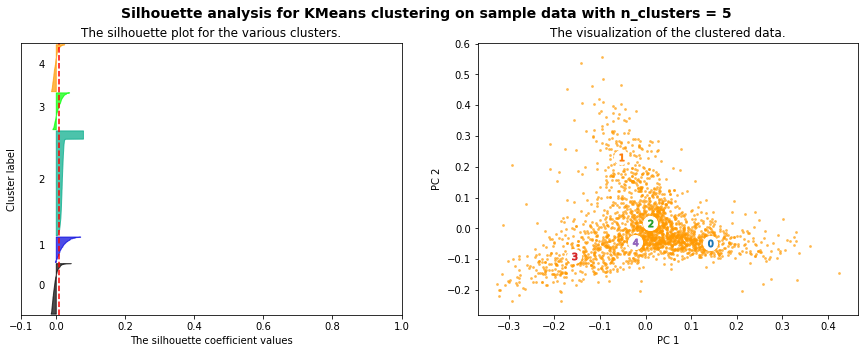

For n_clusters = 5, The average silhouette_score is : 0.010


In [199]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X, reduced_data)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


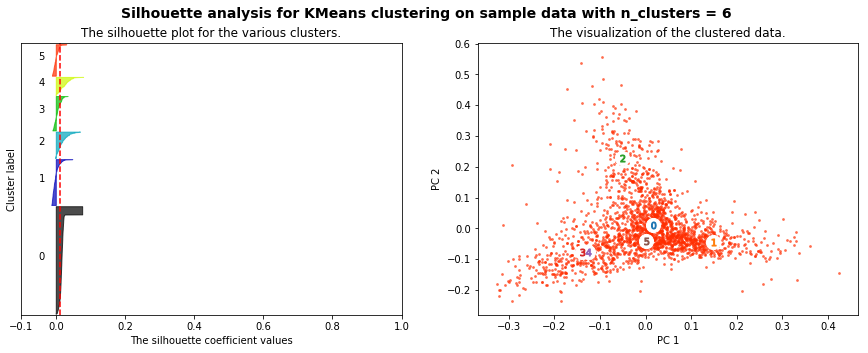

For n_clusters = 6, The average silhouette_score is : 0.012


In [200]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X, reduced_data)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [34]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [35]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [36]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [155]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [156]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [157]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(n_clusters=3)

And visualize:

In [158]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

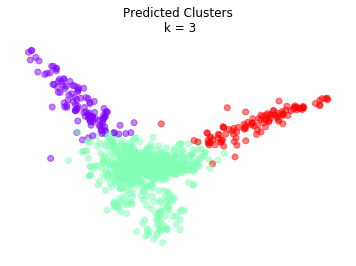

In [159]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [42]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
...,...,...,...,...,...,...,...,...
994,995,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy13.txt,raw/Kennedy/18Jul2005Kennedy13.txt,FOR IMMEDIATE RELEASE Department ...,Kennedy,1
995,996,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy14.txt,raw/Kennedy/18Jul2005Kennedy14.txt,FOR IMMEDIATE RELEASE I welcome t...,Kennedy,1
996,997,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy0.txt,raw/Kennedy/18Jul2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
997,998,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy1.txt,raw/Kennedy/18Jul2006Kennedy1.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [451]:
speeches = pandas.read_csv("presidential_speeches.csv")
speeches = speeches.rename(columns={'Unnamed: 0': 'title', 'President': 'president', 'Date': 'date', 'Speech': 'text'})
speeches['subtype'] = 'Speech'
print(speeches.shape)
speeches.head(2)

(335, 5)


,title,president,date,text,subtype
0,january-20-2021-inaugural-address,Joe Biden,"January 20, 2021","\n \n\n\n\n\n\nChief Justice Roberts, Vic...",Speech
1,january-19-2021-farewell-address,Donald Trump,"January 19, 2021",\n \n\n\n\n\n\nMy fellow Americans: Four ...,Speech


In [452]:
orders = pandas.read_csv("exec_orders_w_text")
orders = orders.rename(columns={'publication_date': 'date', 'order_text': 'text'})
print(orders.shape)
orders.head(2)

(1042, 16)


,Unnamed: 0,citation,document_number,end_page,html_url,pdf_url,type,subtype,date,signing_date,start_page,title,disposition_notes,executive_order_number,president,text
0,0,82 FR 8115,2017-01623,8129,https://www.federalregister.gov/documents/2017...,https://www.govinfo.gov/content/pkg/FR-2017-01...,Presidential Document,Executive Order,01/23/2017,01/17/2017,8115,"Amending the Civil Service Rules, Executive Or...","Amends: EO 13467, June 30, 2008; EO 13488, Jan...",13764.0,barack_obama,\n\nTitle 3—\nThe President\n\nExecutive Order...
1,1,82 FR 7619,2017-01487,7620,https://www.federalregister.gov/documents/2017...,https://www.govinfo.gov/content/pkg/FR-2017-01...,Presidential Document,Executive Order,01/19/2017,01/13/2017,7619,Providing an Order of Succession Within the De...,"Revokes: EO 13557, November 4, 2010\nRevoked b...",13762.0,barack_obama,"\n\n\nExecutive Order 13762 of January 13, 201..."


In [453]:
data = speeches.append(orders[['title', 'president', 'date', 'text', 'subtype']])
data = data[data['text'].notna()]
print(data.shape)
data.head(2)

(1152, 5)


,title,president,date,text,subtype
0,january-20-2021-inaugural-address,Joe Biden,"January 20, 2021","\n \n\n\n\n\n\nChief Justice Roberts, Vic...",Speech
1,january-19-2021-farewell-address,Donald Trump,"January 19, 2021",\n \n\n\n\n\n\nMy fellow Americans: Four ...,Speech


In [349]:
def print_eval_metrics(data, true_label, pred_label):
    print("Evaluation Metrics: ")
    print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(data[true_label], pred_label)))
    print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(data[true_label], pred_label)))
    print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(data[true_label], pred_label)))
    print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(data[true_label], pred_label)))

In [344]:
def KMeans_helper(data, true_label, textColumn, numCategories, max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2'):
    dataTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=max_df, max_features=max_features, min_df=min_df, stop_words=stop_words, norm=norm)
    dataTFVects = dataTFVectorizer.fit_transform(targetDF[textColumn]) 
    
    dataKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
    dataKM.fit(dataTFVects)
    
    print_eval_metrics(data, true_label, dataKM.labels_)
    
    return dataTFVectorizer, dataTFVects, dataKM

In [345]:
def top_words_by_cluster(Vectorizer, KM, numCategories):
    terms = Vectorizer.get_feature_names()
    print("Top terms per cluster:")
    order_centroids = KM.cluster_centers_.argsort()[:, ::-1]
    for i in range(numCategories):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
        print('\n')

In [346]:
def viz_2D(dataTFVects, dataKM, numCategories, color_dict):
    dataPCA = sklearn.decomposition.PCA(n_components = 2).fit(dataTFVects.toarray())
    reducedPCA_data = dataPCA.transform(dataTFVects.toarray())
    
    colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
    colors_p = [colors[l] for l in dataKM.labels_]

    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(5,10))
    ax1.title.set_text('Predicted Clusters\n k = {}'.format(numCategories))
    ax1.set_frame_on(False)
    ax1.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
    
    ax2.title.set_text('True Classes')
    ax2.set_frame_on(False)
    ax2.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_a, alpha = 0.5)
    
    plt.show()

In [347]:
colordict = {
'Speech': 'red',
'Executive Order': 'orange'
    }
colors_a = [colordict[c] for c in data['subtype']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('Speech', 'red'), ('Executive Order', 'orange')])


Number of clusters:  2


Evaluation Metrics: 
Homogeneity: 0.955
Completeness: 0.962
V-measure: 0.958
Adjusted Rand Score: 0.982


Top terms per cluster:
Cluster 0:
 council
 amended
 director
 property
 pursuant
 information
 services
 emergency
 health
 committee


Cluster 1:
 people
 world
 american
 peace
 ve
 new
 know
 applause
 years
 country






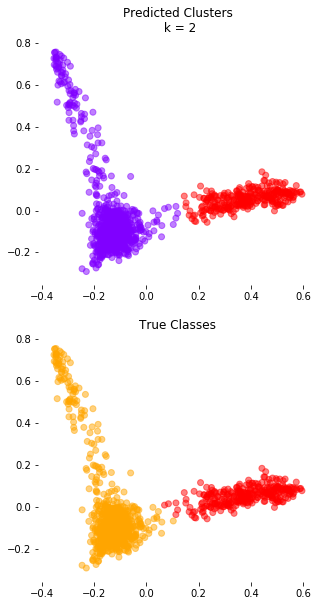

Number of clusters:  3


Evaluation Metrics: 
Homogeneity: 0.955
Completeness: 0.669
V-measure: 0.787
Adjusted Rand Score: 0.775


Top terms per cluster:
Cluster 0:
 property
 pursuant
 blocked
 treasury
 ieepa
 persons
 interests
 emergency
 prohibitions
 entity


Cluster 1:
 people
 world
 american
 peace
 ve
 new
 know
 applause
 years
 country


Cluster 2:
 council
 amended
 director
 information
 health
 committee
 service
 services
 commission
 board






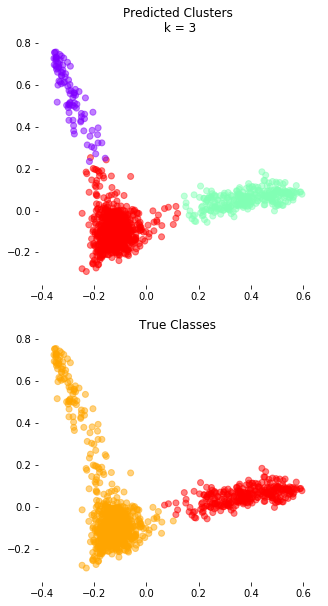

Number of clusters:  4


Evaluation Metrics: 
Homogeneity: 0.973
Completeness: 0.461
V-measure: 0.625
Adjusted Rand Score: 0.467


Top terms per cluster:
Cluster 0:
 council
 director
 information
 health
 commission
 committee
 task
 services
 force
 advisory


Cluster 1:
 people
 world
 american
 peace
 ve
 new
 know
 applause
 years
 country


Cluster 2:
 amended
 schedule
 december
 inserting
 01
 board
 pay
 emergency
 striking
 3195


Cluster 3:
 property
 pursuant
 blocked
 treasury
 ieepa
 persons
 interests
 emergency
 prohibitions
 entity






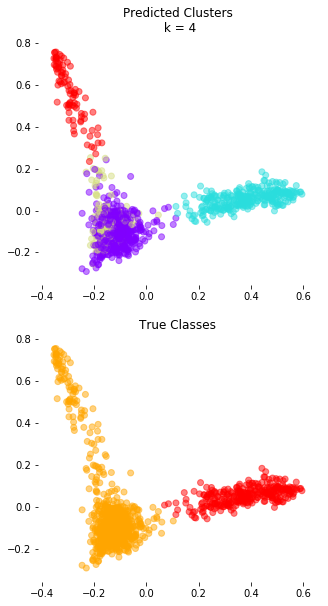

Number of clusters:  5


Evaluation Metrics: 
Homogeneity: 0.971
Completeness: 0.421
V-measure: 0.587
Adjusted Rand Score: 0.411


Top terms per cluster:
Cluster 0:
 people
 world
 american
 peace
 ve
 new
 know
 applause
 years
 country


Cluster 1:
 property
 pursuant
 blocked
 treasury
 persons
 ieepa
 interests
 emergency
 prohibitions
 entity


Cluster 2:
 amended
 board
 01
 december
 inserting
 advisory
 2001
 striking
 emergency
 3195


Cluster 3:
 council
 information
 director
 task
 health
 commission
 force
 services
 committee
 programs


Cluster 4:
 schedule
 pay
 attached
 rates
 payments
 basic
 forth
 set
 senior
 december






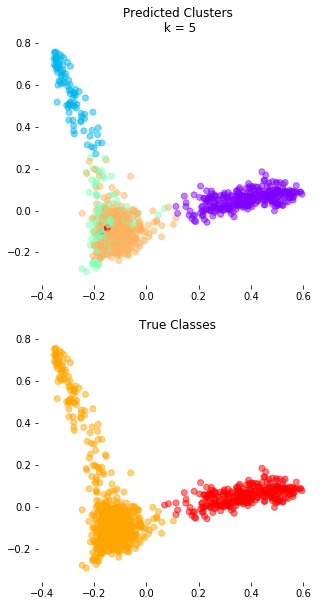

In [351]:
for num in (2,3,4,5):
    print("Number of clusters: ", num)
    targetDF = data
    textColumn = 'text'
    numCategories = num
    print("\n")
    dataTFVectorizer, dataTFVects, dataKM = KMeans_helper(data, 'subtype', textColumn, numCategories)
    print("\n")
    top_words_by_cluster(dataTFVectorizer, dataKM, numCategories)
    print("\n")
    viz_2D(dataTFVects, dataKM, numCategories, colors_a)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


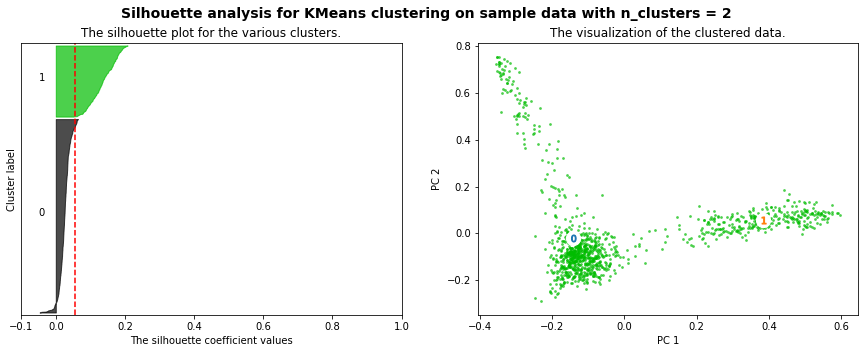

For n_clusters = 2, The average silhouette_score is : 0.055


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


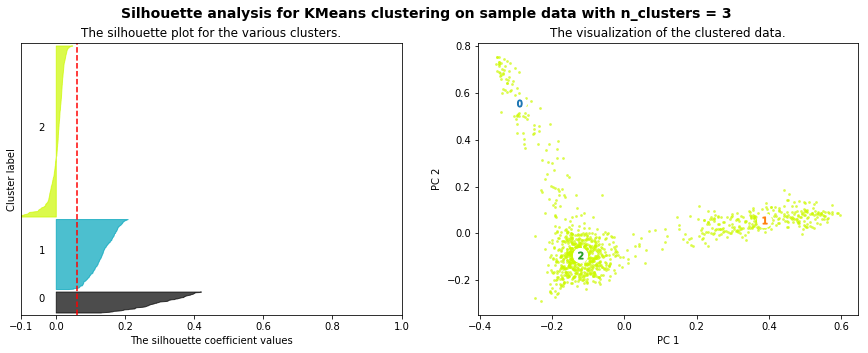

For n_clusters = 3, The average silhouette_score is : 0.061


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


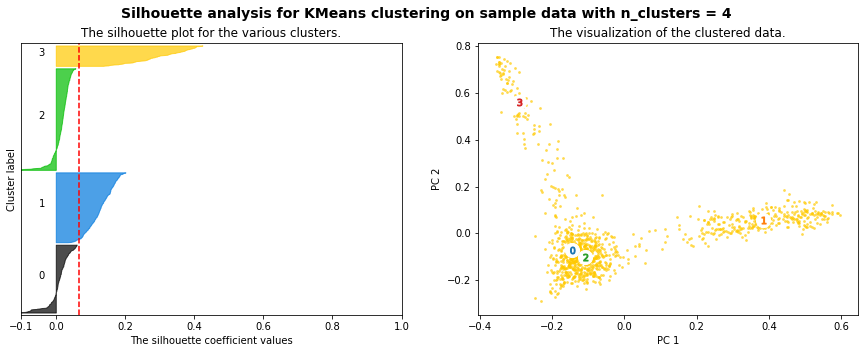

For n_clusters = 4, The average silhouette_score is : 0.066


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


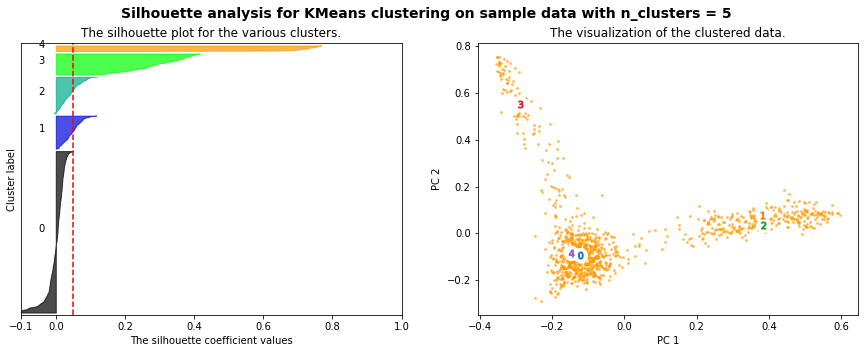

For n_clusters = 5, The average silhouette_score is : 0.050


In [248]:
for n_cluster in range(2,6,1):
    X = dataTFVects.toarray()
    plotSilhouette(n_cluster, X, reducedPCA_data, dataPCA)

So I combined 2 set of documents: presidential speeches and presidential executive orders. Hence, I believe 1 "true" number of clusters is 2: presidential speeches vs. presidential executive orders. And when I tried to use K-means on 2 clusters, the results are pretty decent:

- Evaluation Metrics: 
- Homogeneity: 0.955
- Completeness: 0.962
- V-measure: 0.958
- Adjusted Rand Score: 0.982

which indicates that there're reasonable differences between these 2 sets of documents (which we can see from the top 10 words in each set).

However, using Silhouette analysis, it seems that 4 is the "optimal" number of clusters (silhouette_score is : 0.066). Based on the plot, it looks like the "Executive orders" can further be split into 3 sub-clusters, which is interesting because I originally thought that speeches would differ more from each other. 

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [220]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [221]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [222]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [223]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [224]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [225]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[126.        , 193.        ,   0.        ,   2.        ],
       [195.        , 200.        ,   0.        ,   3.        ],
       [198.        , 201.        ,   0.        ,   4.        ],
       [  5.        , 202.        ,   0.37033177,   5.        ],
       [104.        , 169.        ,   0.40914841,   2.        ],
       [ 10.        ,  44.        ,   0.44134524,   2.        ],
       [ 49.        , 162.        ,   0.45096656,   2.        ],
       [151.        , 204.        ,   0.4553535 ,   3.        ],
       [117.        , 206.        ,   0.4650683 ,   3.        ],
       [  2.        ,  46.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

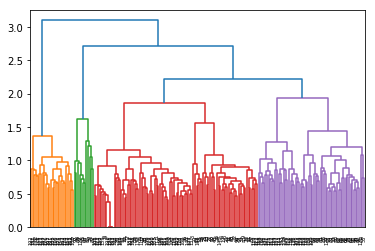

In [226]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

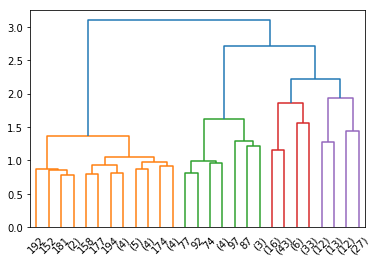

In [50]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [227]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4,
       3, 4, 2, 4, 4, 4, 3, 2, 2, 2, 4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2,
       3, 2, 4, 4, 2, 4, 4, 4, 4, 2, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 2, 4, 4, 3, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3, 1, 1,
       1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3, 1, 3, 3, 1,
       3, 4], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [228]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [229]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,text,category,source_file,kmeans_predictions,wald_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,3,4
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,1,4
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,3,4
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,1,4
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,1,4
...,...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,1,4
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0,2
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0,2
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,1,4


# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [230]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

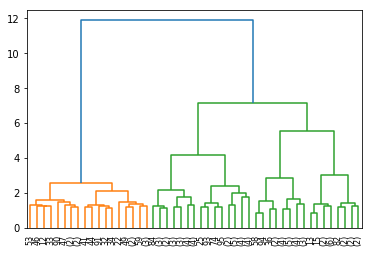

In [231]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [232]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [352]:
dataCoocMat = dataTFVects * dataTFVects.T
dataCoocMat.setdiag(0)
datalinkage_matrix = scipy.cluster.hierarchy.ward(dataCoocMat.toarray())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


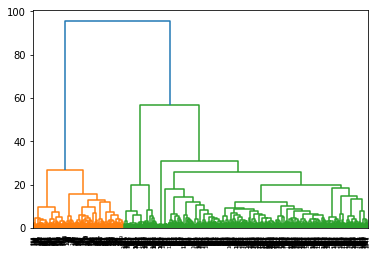

In [353]:
ax1 = scipy.cluster.hierarchy.dendrogram(datalinkage_matrix, get_leaves=True)

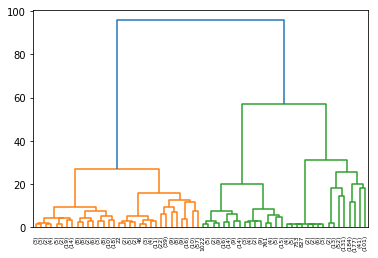

In [354]:
ax2 = scipy.cluster.hierarchy.dendrogram(datalinkage_matrix, p=5, truncate_mode='level', get_leaves=True)

In [358]:
for num in (2,3,4,5):
    print("Number of Clusters: ", num)
    hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(datalinkage_matrix, num, 'maxclust')
    print_eval_metrics(data, 'subtype', hierarchicalClusters_full)
    print("\n")

Number of Clusters:  2
Evaluation Metrics: 
Homogeneity: 0.990
Completeness: 0.989
V-measure: 0.989
Adjusted Rand Score: 0.996


Number of Clusters:  3
Evaluation Metrics: 
Homogeneity: 0.990
Completeness: 0.663
V-measure: 0.794
Adjusted Rand Score: 0.751


Number of Clusters:  4
Evaluation Metrics: 
Homogeneity: 0.990
Completeness: 0.600
V-measure: 0.747
Adjusted Rand Score: 0.704


Number of Clusters:  5
Evaluation Metrics: 
Homogeneity: 0.991
Completeness: 0.507
V-measure: 0.670
Adjusted Rand Score: 0.642




In [364]:
for num in (2,3,4,5):
    print("Number of Clusters: ", num)
    hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(datalinkage_matrix, num, 'distance')
    print_eval_metrics(data, 'subtype', hierarchicalClusters_full)
    print("\n")

Number of Clusters:  2
Evaluation Metrics: 
Homogeneity: 0.998
Completeness: 0.104
V-measure: 0.188
Adjusted Rand Score: 0.005


Number of Clusters:  3
Evaluation Metrics: 
Homogeneity: 0.997
Completeness: 0.121
V-measure: 0.216
Adjusted Rand Score: 0.011


Number of Clusters:  4
Evaluation Metrics: 
Homogeneity: 0.996
Completeness: 0.135
V-measure: 0.238
Adjusted Rand Score: 0.019


Number of Clusters:  5
Evaluation Metrics: 
Homogeneity: 0.996
Completeness: 0.150
V-measure: 0.261
Adjusted Rand Score: 0.030




K-Means (2 clusters):

- Homogeneity: 0.955
- Completeness: 0.962
- V-measure: 0.958
- Adjusted Rand Score: 0.982

Hierarchical (2 clusters, using 'maxclust'):

- Homogeneity: 0.990
- Completeness: 0.989
- V-measure: 0.989
- Adjusted Rand Score: 0.996

Hierarchical (2 clusters, using 'distance', which turns out to be pretty bad for this task):

- Homogeneity: 0.998
- Completeness: 0.104
- V-measure: 0.188
- Adjusted Rand Score: 0.005

It looks like hierarchical clustering using 'maxclust' does a slightly better job at clustering correctly presidential speeches vs executive orders than k-means (but not by a lot though). This kinda makes sense, k-means tends to work better with data with Gaussian-like clusters (equal variance) and hierarchical clustering is better at dealing with non-Gaussian-like clusters. From the figures above, I could see that the 2 "true" clusters aren't very Gaussian-like and they also have quite different variance. So, it kinda makes sense that hierarchical clustering would do a better job.

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [260]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [261]:
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions,tokenized_text,normalized_tokens,reduced_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta...","[contact, brent, carney, ma, announce, worcest..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se...","[follow, temporary, extension, patriot, extra,..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, washi...","[follow, bird, flu, yesterday, belated, respon..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, surpr...","[surprise, enormous, endless, costly, danger, ..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immediate, release, washington, have, c, toda...","[follow, priority, pension, sadly, welcome, ho..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se...","[patrick, leahy, richard, durbin, send, follow..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immediate, release, veteran, s, day, america,...","[veteran, stand, brave, man, woman, sacrifice,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, mr, c...","[convene, track, reauthorize, understand, engl..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se...","[follow, source, cia, leak, ordeal, watergate,..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immediate, release, washington, have, c, sena...","[kerry, announce, approve, direct, army, corp,..."


In [262]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [263]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [264]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [265]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [266]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [267]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(4, 0.9739107)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [268]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [269]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(8, 0.9716256)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.971626,0.000000
101,02Feb2007Kennedy10.txt,"[(9, 0.9950656)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.995066
201,04May2006Kennedy8.txt,"[(1, 0.9976145)]",0.000000,0.997615,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
301,06Jun2007Kennedy1.txt,"[(2, 0.21748455), (4, 0.7807002)]",0.000000,0.000000,0.217485,0.000000,0.780700,0.0,0.000000,0.000000,0.000000,0.000000
401,08Feb2005Kennedy0.txt,"[(0, 0.99338365)]",0.993384,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
501,09Nov2005Kennedy11.txt,"[(4, 0.57202196), (7, 0.3890737)]",0.000000,0.000000,0.000000,0.000000,0.572022,0.0,0.000000,0.389074,0.000000,0.000000
601,11Nov2005Kennedy6.txt,"[(1, 0.9721103)]",0.000000,0.972110,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
701,13Jun2006Kennedy1.txt,"[(0, 0.024801647), (2, 0.9090121), (6, 0.05938...",0.024802,0.000000,0.909012,0.000000,0.000000,0.0,0.059384,0.000000,0.000000,0.000000
801,15Dec2005Kennedy5.txt,"[(2, 0.04789835), (3, 0.4714087), (4, 0.253043...",0.000000,0.000000,0.047898,0.471409,0.253044,0.0,0.000000,0.059034,0.000000,0.167646
901,16May2007Kennedy5.txt,"[(6, 0.95450836)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.954508,0.000000,0.000000,0.000000


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [270]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.0,0.000000,0.000000,0.000000,0.973910,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.971626,0.000000
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.557437,0.000000,0.000000,0.436498
3,0.0,0.110711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.883917,0.000000
4,0.0,0.000000,0.380895,0.015625,0.000000,0.000000,0.286450,0.315492,0.000000,0.000000
5,0.0,0.000000,0.000000,0.451444,0.000000,0.000000,0.000000,0.540828,0.000000,0.000000
6,0.0,0.000000,0.000000,0.000000,0.024384,0.493621,0.473821,0.000000,0.000000,0.000000
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.967713
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.772094,0.000000,0.000000,0.223610
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.967733


First we can visualize as a stacked bar chart:

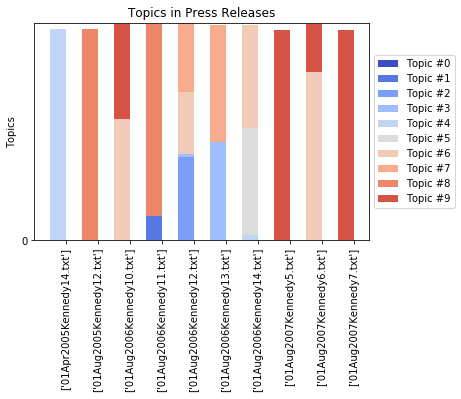

In [271]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

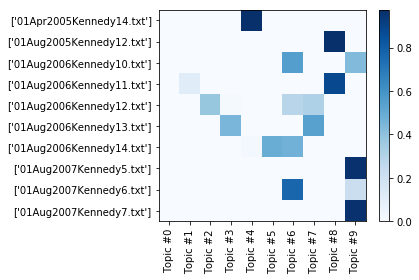

In [272]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [273]:
senlda.show_topic(1)

[('fund', 0.008096144),
 ('head', 0.0072125513),
 ('stem', 0.006644134),
 ('cell', 0.0065072766),
 ('worker', 0.004146041),
 ('science', 0.004136474),
 ('company', 0.0028998493),
 ('agency', 0.0027403482),
 ('unite', 0.0026497804),
 ('medicaid', 0.0025407746)]

And if we want to make a dataFrame:

In [274]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,fund,fund,worker,fund,fund,worker,worker,wage,fund,loan
1,worker,head,fund,wage,worker,pension,fund,minimum,worker,lender
2,asbestos,stem,medicare,minimum,loan,immigrant,wage,worker,head,worker
3,victim,cell,woman,worker,teacher,immigration,lender,fund,agency,fund
4,trust,worker,immigration,victim,aid,company,loan,mental,ireland,rate
5,compensation,science,unite,asbestos,immigration,unite,head,woman,northern,company
6,wage,company,troop,hour,unite,fda,minimum,insurance,pension,pension
7,disease,agency,border,fda,company,woman,company,citizen,provision,troop
8,claim,unite,employer,teacher,hear,citizen,intelligence,association,fail,follow
9,immigration,medicaid,immigrant,bankruptcy,troop,insurance,unite,coverage,fda,aid


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

<Figure size 432x288 with 0 Axes>

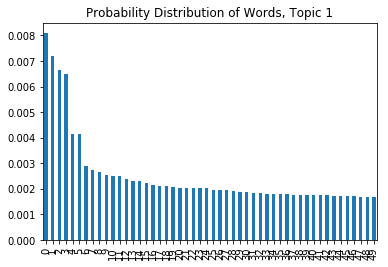

In [275]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [276]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

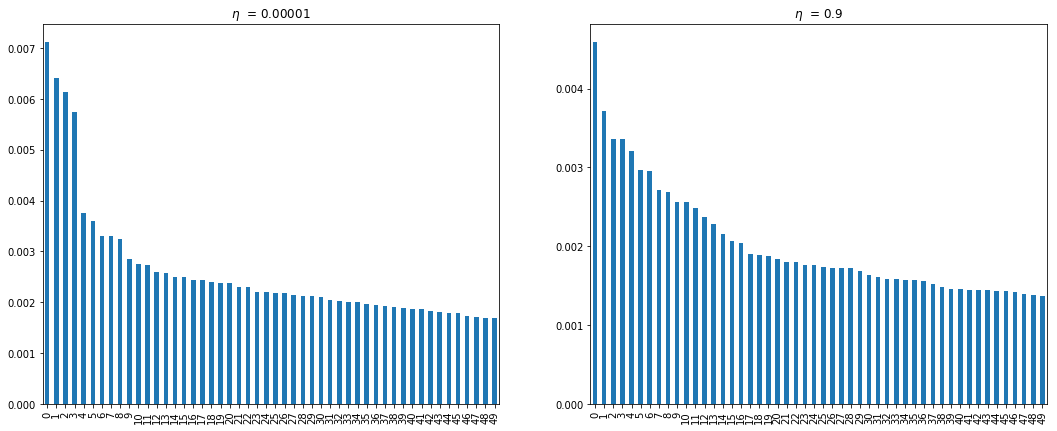

In [277]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [525]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]
    
def prepare_tokens(data, text_col, serial_name, Vectorizer):
    data['tokenized_text'] = data[text_col].apply(lambda x: lucem_illud.word_tokenize(x))
    data['normalized_tokens'] = data['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))
    data['reduced_tokens'] = data['normalized_tokens'].apply(lambda x: dropMissing(x, Vectorizer.vocabulary_.keys()))

    dictionary = gensim.corpora.Dictionary(data['reduced_tokens'])

    corpus = [dictionary.doc2bow(text) for text in data['reduced_tokens']]

    gensim.corpora.MmCorpus.serialize(serial_name, corpus)
    senmm = gensim.corpora.MmCorpus(serial_name)
    
    return senmm, dictionary

def train_lda(senmm, dictionary, num_topics, title_col, alpha='auto', eta='auto'):
    senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=num_topics, alpha=alpha, eta=eta)

    ldaDF = pandas.DataFrame({
            'name' : data[title_col],
            'topics' : [senlda[dictionary.doc2bow(l)] for l in data['reduced_tokens']]
        })
    
    #Dict to temporally hold the probabilities
    topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

    #Load them into the dict
    for index, topicTuples in enumerate(ldaDF['topics']):
        for topicNum, prob in topicTuples:
            topicsProbDict[topicNum][index] = prob

    #Update the DataFrame
    for topicNum in range(senlda.num_topics):
        ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
    
    return senlda, ldaDF

In [528]:
dataTFVectorizer, dataTFVects, dataKM = KMeans_helper(data, 'subtype', 'text', 2)

Evaluation Metrics: 
Homogeneity: 0.970
Completeness: 0.975
V-measure: 0.973
Adjusted Rand Score: 0.989


In [529]:
senmm, dictionary = prepare_tokens(data, 'text', 'speech', dataTFVectorizer)

Number of topics:  2
    Topic_0      Topic_1
0      year      include
1    people  information
2      work      service
3  american       people
4   include       nation
5    nation        world
6   program     pursuant
7       new       action
8     world          new
9     force     director


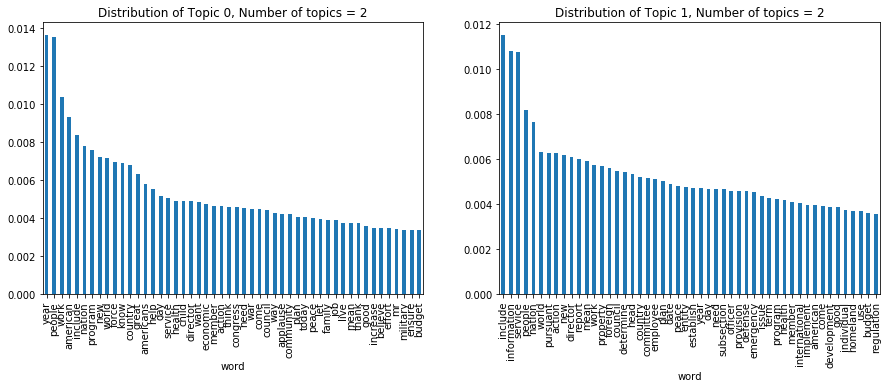

Number of topics:  5
    Topic_0      Topic_1   Topic_2      Topic_3  Topic_4
0    people     director   service      include   people
1      work       people   include  information     year
2      year         work    people      program   nation
3  american        world     force         year      new
4   country      include      year       report     work
5      know  information      work      service    world
6     world       nation    action         head    peace
7    nation          new  american       nation    great
8      help     american  director       action     know
9  applause         year      plan      defense  country


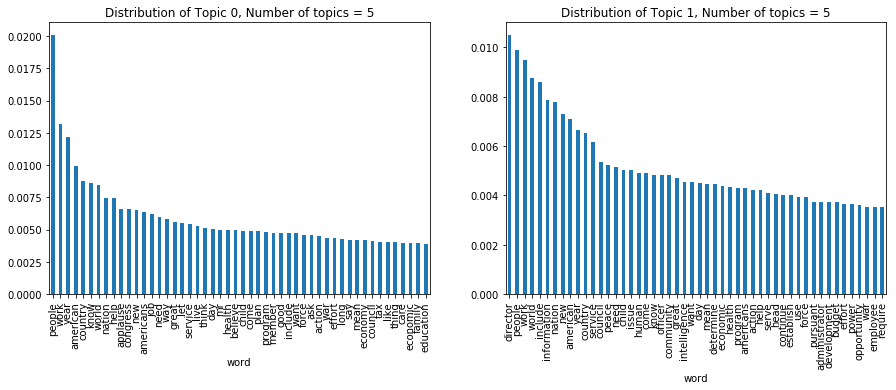

Number of topics:  10
    Topic_0      Topic_1      Topic_2   Topic_3      Topic_4   Topic_5  \
0   include  information      include    people       people    people   
1    nation      service      council      year         year  american   
2   service         year     director      work         work      work   
3      year      include       health     think     american   include   
4    people       people      service   program          new      year   
5      work         work  information  american      country     world   
6   country         head     homeland  congress         know   country   
7  property       action       people     child        force    nation   
8     world      program         head      know  information       new   
9  american        issue          new    nation      include   program   

    Topic_6   Topic_7   Topic_8      Topic_9  
0    people      year    people      include  
1    nation   program   include      council  
2      work   include 

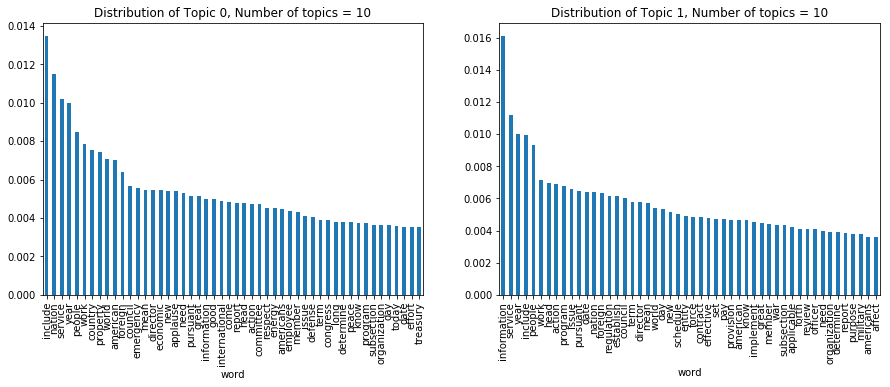

In [530]:
for num_top in (2, 5, 10):
    print("Number of topics: ", num_top)
    senlda, ldaDF = train_lda(senmm, dictionary, num_top, 'title', alpha=0.5, eta=0.5)
    
    topicsDict = {}
    for topicNum in range(senlda.num_topics):
        topicWords = [w for w, p in senlda.show_topic(topicNum)]
        topicsDict['Topic_{}'.format(topicNum)] = topicWords

    wordRanksDF = pandas.DataFrame(topicsDict)
    print(wordRanksDF)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    topic1_df = pandas.DataFrame(senlda.show_topic(0, topn=50), columns = ['word', 'prob'])
    topic1_df.plot.bar(legend = False, ax = ax1, x='word', y='prob', title = 'Distribution of Topic 0, Number of topics = ' + str(num_top))
    topic2_df = pandas.DataFrame(senlda.show_topic(1, topn=50), columns = ['word', 'prob'])
    topic2_df.plot.bar(legend = False, ax = ax2, x='word', y='prob', title = 'Distribution of Topic 1, Number of topics = ' + str(num_top))
    plt.show()

It looks like the topics top words are quite similar in my corpus. As the number of topics increase, it looks like the distribution (and also the top words) between topics becomes more similar as the "differentiation" between topics become less.

Eta:  0.9
       Topic_0   Topic_1      Topic_2   Topic_3    Topic_4
0         year    people      include    people       work
1       people      year      council      year    include
2  information       new         year   include     people
3      include    nation  information    nation    service
4     american   country      service     world    program
5         work  american      program      work  community
6        world      know       health  american      force
7      program      work       people       new    country
8      country     world       member     force      world
9      service   include     director   service        new


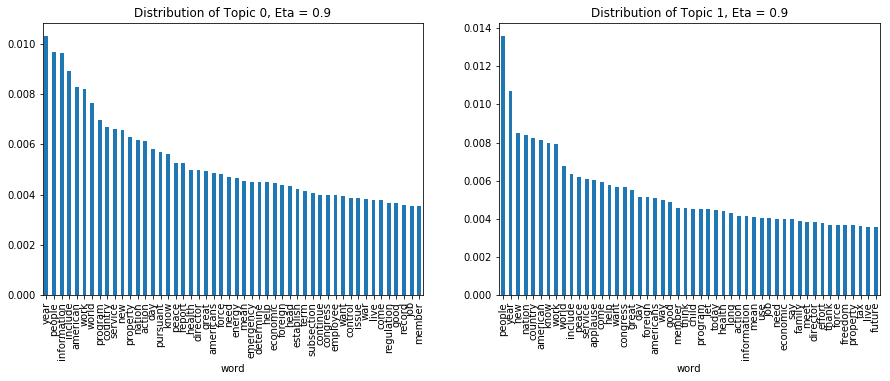

Eta:  1e-05
    Topic_0   Topic_1      Topic_2   Topic_3   Topic_4
0   include    people  information   include    people
1      year      year       people   service      year
2    people  american         work      work   service
3    nation    nation        world    people  american
4     force      work      country      year     world
5   program     world         year    nation      work
6      work       new      program    action       new
7   service   include      include   council   include
8  director     great          new  american    nation
9   country     peace     director  property   country


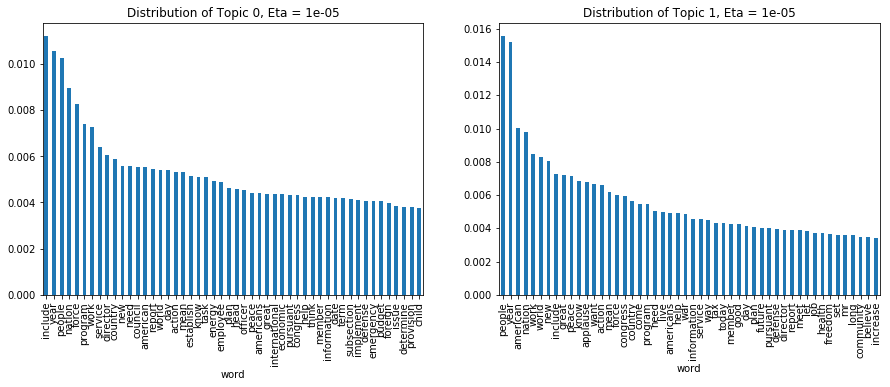

In [531]:
for eta in (0.9, 0.00001):
    print("Eta: ", eta)
    senlda, ldaDF = train_lda(senmm, dictionary, 5, 'title', alpha=0.5, eta=eta)
    
    topicsDict = {}
    for topicNum in range(senlda.num_topics):
        topicWords = [w for w, p in senlda.show_topic(topicNum)]
        topicsDict['Topic_{}'.format(topicNum)] = topicWords

    wordRanksDF = pandas.DataFrame(topicsDict)
    print(wordRanksDF)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    topic1_df = pandas.DataFrame(senlda.show_topic(0, topn=50), columns = ['word', 'prob'])
    topic1_df.plot.bar(legend = False, ax = ax1, x='word', y='prob', title = 'Distribution of Topic 0, Eta = ' + str(eta))
    topic2_df = pandas.DataFrame(senlda.show_topic(1, topn=50), columns = ['word', 'prob'])
    topic2_df.plot.bar(legend = False, ax = ax2, x='word', y='prob', title = 'Distribution of Topic 1, Eta = ' + str(eta))
    plt.show()

From these figures, it's not super clear to me how eta is changing the distribution of topics as the topics are really similar in my opinion. However, it does look a little bit like: as eta gets larger, the distribution between topics becomes more different (i.e, topics are more "differentiated").

Alpha:  0.9
       Topic_0      Topic_1   Topic_2   Topic_3   Topic_4
0       people      include      year   service    people
1        world         work   country    people      year
2          new      service      work      year   include
3         year  information    people   include  american
4  information       people    nation    nation       new
5       nation         year   include   council     world
6      include      program  director       new      work
7         work       action  american  american     force
8         know       health   program   program    nation
9     american    americans     world     force    report


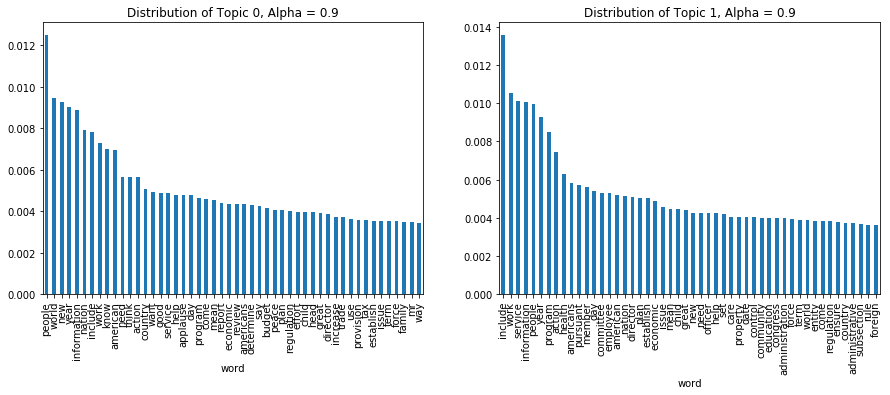

Alpha:  1e-05
       Topic_0   Topic_1  Topic_2   Topic_3     Topic_4
0       people    people     work    people     include
1      include      year   people   include     service
2      program      work  include      year        year
3         year      know  defense      work      people
4       nation   council  country    nation      nation
5     american     world     year  american    american
6  information     great  service       new       force
7      country       new    world   service     country
8        world  congress     mean   council  subsection
9      service   include      new  director       peace


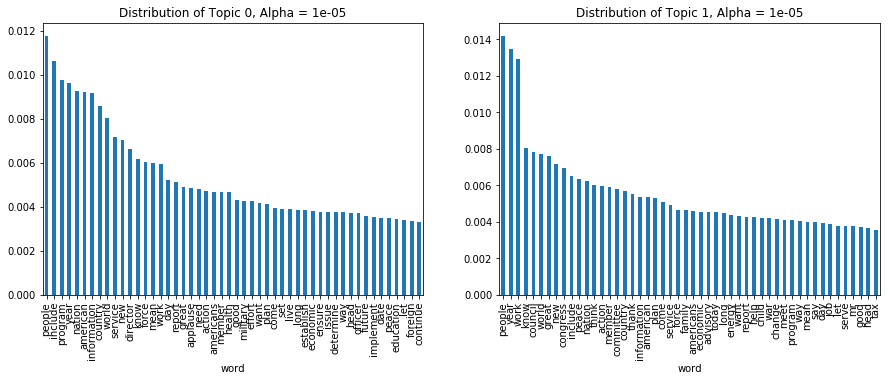

In [532]:
for alpha in (0.9, 0.00001):
    print("Alpha: ", alpha)
    senlda, ldaDF = train_lda(senmm, dictionary, 5, 'title', alpha=alpha, eta=0.5)
    
    topicsDict = {}
    for topicNum in range(senlda.num_topics):
        topicWords = [w for w, p in senlda.show_topic(topicNum)]
        topicsDict['Topic_{}'.format(topicNum)] = topicWords

    wordRanksDF = pandas.DataFrame(topicsDict)
    print(wordRanksDF)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    topic1_df = pandas.DataFrame(senlda.show_topic(0, topn=50), columns = ['word', 'prob'])
    topic1_df.plot.bar(legend = False, ax = ax1, x='word', y='prob', title = 'Distribution of Topic 0, Alpha = ' + str(alpha))
    topic2_df = pandas.DataFrame(senlda.show_topic(1, topn=50), columns = ['word', 'prob'])
    topic2_df.plot.bar(legend = False, ax = ax2, x='word', y='prob', title = 'Distribution of Topic 1, Alpha = ' + str(alpha))
    plt.show()

From these figures, again, it's not super clear to me how alpha is changing the distribution of topics as the topics are really similar in my opinion. However, it does look a little bit like: alpha is doing the oposite of eta, as alpha gets larger, the distribution between topics becomes more similar (i.e, topics are more similar).

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [382]:
corpora_address = "../data/SOAP"

In [383]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [384]:
import zipfile
import pandas as pd

In [385]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [386]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [387]:
soap_dict = {}

In [388]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [389]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [390]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [391]:
i = 0

In [392]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [393]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Reporter, Is, there, anything, you, regret,..."
1,As the World Turns,"[@!Katie, Okay, I, know, these, words, are, lo..."
2,Bold and Beautiful,"[@!Bridget, What, did, you, say, @!Deacon, Jus..."
3,Days of Our Lives,"[@!Maggie, How, are, you, doing, @!Victor, Fin..."
4,General Hospital,"[@!Luke, I, signed, my, divorce, papers, You, ..."
5,Guiding Light,"[@!Dax, I, take, it, everything, is, well, wit..."
6,One Life to Live,"[@!Blair, Excuse, me, @!Todd, Why, Did, you, d..."
7,Passions,"[@!Julian, Let, 's, drink, up, It, 's, not, ev..."
8,Port Charles,"[@!Frank, Hey, @!Karen, Hey, You, still, on, d..."
9,Young and Restless,"[@!Katherine, Any, sign, of, your, daddy, swee..."


Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [394]:
dool = soap_df['Tokenized Texts'][9]

In [395]:
' '.join(dool[0:1500])

"@!Katherine Any sign of your daddy sweetheart @!Nikki They 'll be here soon @!Katherine They said they 're on their way @!Noah They 're here Daddy 's home @!Nicholas Where 's my boy @!Noah Yea Why are you breathing so funny Daddy @!Nicholas Because I ran all the way here I could n't wait to see you @!Katherine It 's finally over @!Nikki Thank God @!Miguel Congratulations Victoria @!Victoria Thank you Miguel You 're looking at a real hero If it were n't for Ryan Nicholas would n't be here with us @!Katherine You look wonderful Nicholas @!Nicholas I feel wonderful @!Katherine I told you your daddy was coming home @!Noah And you 're never leaving again are you Daddy @!Nicholas That 's right never Oh come on @!Ryan Welcome home Nicholas @!Nicholas Thanks @!Rianna Do n't forget your medication @!Raul No more triple chocolate cake @!Billy Been there done that @!Raul Yeah right @!Billy Hey rough We 're here for you all right @!Raul What 's rough is spending one more minute in this place @!Ri

In [396]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [397]:
import networkx as nx

In [398]:
actor_network = nx.Graph()

In [399]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [400]:
i = 0

In [401]:
all_texts = []

In [403]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud.normalizeTokens(dool[i:j]))

KeyboardInterrupt: 

In [ ]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [ ]:
all_texts[0:10]

In [ ]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [ ]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [ ]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [ ]:
doollda.show_topics()

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [ ]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [ ]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [ ]:
from gensim.matutils import kullback_leibler

In [ ]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [ ]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

In [ ]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [404]:
corpora_address = "../data/COHA"

In [406]:
coha_texts = lucem_illud.loadDavies(corpora_address, return_raw=True)

text_2000s_scc.zip
text_1990s_bsj.zip


In [407]:
list(coha_texts.keys())[0:5]

['mag_2000_366116.txt',
 'mag_2000_366117.txt',
 'mag_2000_366201.txt',
 'mag_2000_366202.txt',
 'mag_2000_366203.txt']

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [408]:
coha_genres = {}
coha_years = {}

In [409]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [410]:
coha_genres.keys()

dict_keys(['mag', 'nf', 'fic', 'news'])

In [411]:
coha_years.keys()

dict_keys(['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999'])

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [412]:
import collections

In [413]:
years = []
year_lens = []

In [414]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [415]:
years[0], years[-1]

('1990', '2009')

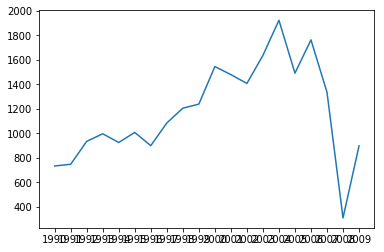

In [416]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [424]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
docs_per_year = [0, 0, 0, 0, 0]
i = 0

In [425]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the 
    if i < 70:
        docs_per_year[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_year[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_year[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_year[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_year[4] += len(coha_years[year_info]) - large_files
    i += 1

KeyboardInterrupt: 

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [420]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [421]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [427]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)

In [428]:
final_corpus= []

In [429]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice. 

In [430]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [ ]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [ ]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [ ]:
from gensim.models import ldaseqmodel

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

In [ ]:
ldaseq.print_topics(time=0)[1]

In [ ]:
ldaseq.print_topics(time=4)[1]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [ ]:
ldaseq.save("ldaseqmodel")

In [ ]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

In [624]:
data_small = data[['date', 'text']]
data_small['year'] = data_small['date'].str.slice(6,10)
data_small = data_small[data_small['text'].notna()]
data_small = data_small[['year','text']].sort_values(by='year')
data_small = data_small[data_small['year'].isin(['2016','2017','2018','2019','2020'])][::5]
data_small['tokenized_text'] = data_small['text'].apply(lambda x: lucem_illud.word_tokenize(x))
data_small['normalized_tokens'] = data_small['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))
data_small['reduced_tokens'] = data_small['normalized_tokens'].apply(lambda x: dropMissing(x, dataTFVectorizer.vocabulary_.keys()))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [625]:
data_small.shape[0]

51

In [626]:
docs_per_time_slice = [0,0,0,0,0]
y_2016 = []
y_2017 = []
y_2018 = []
y_2019 = []
y_2020 = []


for i in range(data_small.shape[0]):
    if data_small.iloc[i]['year'] == '2016':
        y_2016.append(data_small.iloc[i]['reduced_tokens'])
        docs_per_time_slice[0] += 1
    if data_small.iloc[i]['year'] == '2017':
        y_2017.append(data_small.iloc[i]['reduced_tokens'])
        docs_per_time_slice[1] += 1
    if data_small.iloc[i]['year'] == '2018':
        y_2018.append(data_small.iloc[i]['reduced_tokens'])
        docs_per_time_slice[2] += 1
    if data_small.iloc[i]['year'] == '2019':
        y_2019.append(data_small.iloc[i]['reduced_tokens'])
        docs_per_time_slice[3] += 1
    if data_small.iloc[i]['year'] == '2020':
        y_2020.append(data_small.iloc[i]['reduced_tokens'])
        docs_per_time_slice[4] += 1

In [627]:
final_corpus = y_2016 + y_2017 + y_2018 + y_2019 + y_2020

In [628]:
docs_per_time_slice

[9, 12, 7, 10, 13]

In [629]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [630]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [634]:
gensim.corpora.MmCorpus.serialize('data.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('data.mm')

In [635]:
from gensim.models import ldaseqmodel

In [636]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [643]:
ldaseq.print_topics(time=0)[0]

[('council', 0.022609753897631823),
 ('american', 0.01822342362074955),
 ('include', 0.017395038669627085),
 ('domestic', 0.012488119689307615),
 ('head', 0.012394564408563614),
 ('plan', 0.012300710067202134),
 ('labor', 0.012162518621506248),
 ('date', 0.01163386574919016),
 ('applicable', 0.010837915726466764),
 ('budget', 0.010574738521936054),
 ('increase', 0.01045967942207186),
 ('director', 0.010164706563073353),
 ('implement', 0.009937959987366598),
 ('service', 0.009870389942262454),
 ('health', 0.009821404415644289),
 ('report', 0.009804021569040373),
 ('year', 0.009757593857085915),
 ('use', 0.009498962067284296),
 ('require', 0.009229676674233762),
 ('improve', 0.00917215399403512)]

In [644]:
ldaseq.print_topics(time=1)[0]

[('council', 0.022808910108753994),
 ('include', 0.017329722202539633),
 ('american', 0.017186796060274217),
 ('plan', 0.012574559861695898),
 ('domestic', 0.012529857724465784),
 ('head', 0.01233695912485984),
 ('labor', 0.012190647160848953),
 ('date', 0.011439425755776318),
 ('applicable', 0.01088023449649919),
 ('increase', 0.010546050143617664),
 ('budget', 0.010438844380794973),
 ('director', 0.010083822329576525),
 ('implement', 0.01002315580977077),
 ('health', 0.009992779031795499),
 ('service', 0.009962901038590469),
 ('year', 0.009829561571615228),
 ('report', 0.009787132289281712),
 ('use', 0.00934977025686486),
 ('improve', 0.009326333497842886),
 ('require', 0.009239811990996919)]

In [645]:
ldaseq.print_topics(time=2)[0]

[('council', 0.02261387439328482),
 ('include', 0.017270736745682105),
 ('american', 0.01629382096734619),
 ('plan', 0.01290546108490549),
 ('domestic', 0.012572752266610655),
 ('head', 0.012204167682761726),
 ('labor', 0.012059974661332648),
 ('date', 0.011225563085021883),
 ('applicable', 0.01093988325628007),
 ('increase', 0.010681995501310484),
 ('budget', 0.010259164578519428),
 ('health', 0.010214254686560521),
 ('service', 0.010055474353618862),
 ('implement', 0.010000345050231388),
 ('director', 0.009950851554426324),
 ('year', 0.009927797290693359),
 ('report', 0.009774503040864345),
 ('improve', 0.009463904533944715),
 ('require', 0.009282252903304507),
 ('use', 0.009161729014583639)]

In [646]:
ldaseq.print_topics(time=3)[0]

[('council', 0.022375584312303916),
 ('include', 0.017217240230981843),
 ('american', 0.01633688448471088),
 ('domestic', 0.012581636201198877),
 ('head', 0.012363212283106457),
 ('plan', 0.012267800931773898),
 ('labor', 0.012154727135127526),
 ('date', 0.011275182766695023),
 ('applicable', 0.011006846173981743),
 ('increase', 0.010851370679376483),
 ('health', 0.010262053640214912),
 ('budget', 0.01025060392244614),
 ('implement', 0.01002931329371126),
 ('service', 0.009981871200043029),
 ('year', 0.009978497900387946),
 ('director', 0.00994639025108258),
 ('report', 0.009932836995458898),
 ('require', 0.009366015957615237),
 ('improve', 0.00934453796791451),
 ('action', 0.009058567779189121)]

In [647]:
ldaseq.print_topics(time=4)[0]

[('council', 0.02346518962435351),
 ('include', 0.01725069009392408),
 ('american', 0.01670646108959373),
 ('head', 0.012634033926450551),
 ('domestic', 0.012592661202414819),
 ('labor', 0.012330570114665254),
 ('plan', 0.012049811841693151),
 ('date', 0.0111916395483176),
 ('applicable', 0.011074658904761196),
 ('increase', 0.010751317941345453),
 ('budget', 0.010301345408356855),
 ('health', 0.010295496827972478),
 ('implement', 0.010063725286525884),
 ('director', 0.010046526778128903),
 ('year', 0.009945810729396517),
 ('service', 0.00992752289029904),
 ('report', 0.009882569499633512),
 ('require', 0.009400179307321978),
 ('improve', 0.009246938350701256),
 ('action', 0.009183109013315411)]

Hmm, it looks like the topics distribution hasn't changed much in my corpus within the past 5 years. I probably would need to extend the period and include more texts in my model. I'm sorry, the sequen